In [76]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import glob 
import math
import h5py
import os
from statistics import median

import sys 
  
# path of utils folder  
sys.path.insert(0, "/Users/sinakling/projects/pRF_analysis/analysis_code/utils") 
from eyetrack_utils import *

In [87]:
# Load settings 

with open('/Users/sinakling/projects/pRF_analysis/RetinoMaps/eyetracking/dev/pRF_behavior_settings.json') as f:
    settings = json.load(f)

# Load main experiment settings 
num_run = settings.get('num_run')
num_seq = settings.get('num_seq')
seq_trs = settings.get('seq_trs')
eye_mov_seq = settings.get('eye_mov_seq')
trials_seq = settings.get("trials_seq")
rads = settings.get('rads')
pursuits_tr = np.arange(0,seq_trs,2)
saccades_tr = np.arange(1,seq_trs,2)
eyetracking_sampling = settings.get("eyetrack_sampling")
screen_size = settings.get('screen_size')
ppd = settings.get('ppd')

# Define file list
main_dir = settings.get('main_dir_mac')


# Preprocessing method settings
blinks_rm = settings.get("blinks_remove")
# Handle optional fields
drift_corr = settings.get("drift_corr", False)  # Default to False if not defined
downsampling = settings.get("downsampling", False)  
smoothing = settings.get("smoothing", False)



subject = 'sub-14'
task = 'pRF'
ses = 'ses-01'
eye = 'eye1'

file_dir_save_base = f'{main_dir}/derivatives/pp_data'
if not os.path.exists(f"{file_dir_save_base}/{subject}/eyetracking"): 
    os.makedirs(f"{file_dir_save_base}/{subject}/eyetracking") 

file_dir_save = f"{file_dir_save_base}/{subject}/eyetracking"


In [88]:
# Extrat data from physio and physioevents as dataframes 
df_event_runs = extract_data(main_dir, subject, task, ses, num_run, eye, file_type = "physioevents")
df_data_runs = extract_data(main_dir, subject, task, ses, num_run, eye, file_type = "physio")

In [ ]:
# Extract triggers
# Initialize arrays to store results
eye_data_runs_list = []

time_start_eye = np.zeros((1, num_run))
time_end_eye = np.zeros((1, num_run))
time_start_seq = np.zeros((num_seq, num_run))
time_end_seq = np.zeros((num_seq, num_run))
time_start_trial = np.zeros((seq_trs, num_seq, num_run))
time_end_trial = np.zeros((seq_trs, num_seq, num_run))

# Lists to collect record lines
record_lines = []
ongoing_trials = {}

# Regex patterns for matching
record_start_pattern = r'RECORD_START'
record_stop_pattern = r'RECORD_STOP'
seq_start_pattern = r'sequence\s(\d+)\sstarted'
seq_stop_pattern = r'sequence\s(\d+)\sstopped'
trial_onset_pattern = r'trial\s(\d+)\sonset'
trial_offset_pattern = r'trial\s(\d+)\soffset'
seq_9_stop_pattern = settings.get("last_trial_pattern")
seq_1_start_pattern = settings.get("first_trial_pattern")

# Loop through the 'messages' column to extract the patterns
for run_idx, df in enumerate(df_event_runs):
    for index, row in df.iterrows():
        message = row['message']
        
        if pd.isna(message):
            continue  # Skip if NaN
        
        # Check for RECORD_START and RECORD_STOP
        if re.search(record_start_pattern, message):
            record_lines.append(row['onset'])
        elif re.search(record_stop_pattern, message):
            record_lines.append(row['onset'])
        
        # Check for sequence 1 started
        if re.search(seq_1_start_pattern, message):
            time_start_eye[0, run_idx] = row['onset']  # Store by run index
            

        # Check for sequence start
        seq_start_match = re.search(seq_start_pattern, message)
        if seq_start_match:
            seq_num = int(seq_start_match.group(1))
            last_seq_num = seq_num  # Save sequence number for trial matching
            time_start_seq[seq_num - 1, run_idx] = row['onset']  

        # Check for sequence stop
        seq_stop_match = re.search(seq_stop_pattern, message)
        if seq_stop_match:
            seq_num = int(seq_stop_match.group(1))
            time_end_seq[seq_num - 1, run_idx] = row['onset']  
        # Check for sequence stop
        seq_stop_match = re.search(seq_stop_pattern, message)
        if seq_stop_match:
            seq_num = int(seq_stop_match.group(1))
            time_end_seq[seq_num - 1, run_idx] = row['onset']

        # Check for trial onset
        trial_onset_match = re.search(trial_onset_pattern, message)
        if trial_onset_match:
            trial_num = int(trial_onset_match.group(1))
            if last_seq_num is not None:  # Ensure sequence has been identified
                time_start_trial[trial_num - 1, last_seq_num - 1, run_idx] = row['onset']
                # Store ongoing trial in case offset is found later
                ongoing_trials[trial_num] = row['onset']

        # Check for trial offset (ensure it's stored after the onset)
        trial_offset_match = re.search(trial_offset_pattern, message)
        if trial_offset_match:
            trial_num = int(trial_offset_match.group(1))
            # Check if this trial has an ongoing onset recorded
            if trial_num in ongoing_trials:
                if last_seq_num is not None:
                    time_end_trial[trial_num - 1, last_seq_num - 1, run_idx] = row['onset']
                    del ongoing_trials[trial_num]  # Remove from ongoing trials as offset is found
            else:
                # Trial offset found without a matching onset, this means it was out of order
                print(f"Out-of-order trial offset found for trial {trial_num}, but onset wasn't found.")
            


        # Check for sequence 9 stopped
        if re.search(seq_9_stop_pattern, message):
            time_end_eye[0, run_idx] = row['onset']
            
            
    
    # Filter for only timestamps between first and last trial 
    eye_data_run = df_data_runs[run_idx][(df_data_runs[run_idx]['timestamp'] >= time_start_eye[0, run_idx]) & 
                       (df_data_runs[run_idx]['timestamp'] <= time_end_eye[0, run_idx])]
    
    plt_1 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_run['x_coordinate'])
    #plt.show()

    eye_data_run_array = eye_data_run[['timestamp', 'x_coordinate', 'y_coordinate', 'pupil_size']].to_numpy()

    eye_data_runs_list.append(eye_data_run_array)

            

In [101]:
def blinkrm_pupil_off(samples, sampling_rate=1000):
    """
    Replace blinks in eye-tracking data (where pupil size is zero) with NaN and extend blink duration for smoothing.

    Args:
        samples (np.array): 4D array of eye-tracking data (time, X, Y, pupil).
        sampling_rate (int): Sampling rate of the data, default is 1000 Hz.

    Returns:
        np.array: Cleaned eye-tracking data with blinks replaced by NaN.
"""
    import numpy as np 
    import matplotlib.pyplot as plt
    print(' - blink replacement with NaN')
    addms2blink = 200  # ms added to end of blink
    blink_duration_extension = int(sampling_rate / 1000 * addms2blink)
    
    # Detect blinks based on pupil size being 0
    blink_indices = np.where(samples[:, 3] == 0)[0]
    
    blink_bool = np.zeros(len(samples), dtype=bool)
    
    for idx in blink_indices:
        blink_bool[idx] = True
    
    # Adding 50 ms extension to the detected blinks
    for idx in blink_indices:
        start_idx = max(0, idx - blink_duration_extension)
        end_idx = min(len(samples), idx + blink_duration_extension + 1)
        blink_bool[start_idx:end_idx] = True
    
    # Add another 100 ms to the beginning and ending of each blink
    smth_kernel = np.ones(int(sampling_rate / 1000 * 200)) / (sampling_rate / 1000 * 200)
    extended_blink_bool = np.convolve(blink_bool, smth_kernel, mode='same') > 0
    
    # Replace blink points in the samples with NaN
    cleaned_samples = samples.copy()
    cleaned_samples[extended_blink_bool, 1:] = np.nan 

    plt_2 = plt.figure(figsize=(15, 6))
    plt.title("Blink removed timeseries")
    plt.xlabel('x-coordinate', fontweight='bold')
    plt.plot(cleaned_samples[:,1])
    plt.show()
    
    return cleaned_samples


In [ ]:
# Remove blinks 
# Put nan for blink time

if blinks_rm == 'pupil_off':
    eye_data_runs_nan_blink_run_1 = blinkrm_pupil_off(eye_data_runs_list[0],eyetracking_sampling)
    eye_data_runs_nan_blink_run_2 = blinkrm_pupil_off(eye_data_runs_list[1],eyetracking_sampling)

    plt_2 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_runs_nan_blink_run_1[:,2])
    #plt.show()
else: 
    print("No blink removal method specified")

In [ ]:
# Center, flip Y axis and convert to dva 
eye_data_runs_nan_blink_run_1[:,1] = (eye_data_runs_nan_blink_run_1[:,1] - (screen_size[0]/2))/ppd
eye_data_runs_nan_blink_run_1[:,2] = -1.0*((eye_data_runs_nan_blink_run_1[:,2] - (screen_size[1]/2))/ppd)

eye_data_runs_nan_blink_run_2[:,1] = (eye_data_runs_nan_blink_run_2[:,1] - (screen_size[0]/2))/ppd
eye_data_runs_nan_blink_run_2[:,2] = -1.0*((eye_data_runs_nan_blink_run_2[:,2] - (screen_size[1]/2))/ppd)

plt_3 = plt.figure(figsize=(15, 6))
plt.plot(eye_data_runs_nan_blink_run_1[:,1])
plt.ylim([-5,5])
#plt.show()

In [93]:
eye_data_x_run_01_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_1[:,1])
eye_data_y_run_01_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_1[:,2])
eye_data_p_run_01_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_1[:,3])

- interpolating data
- interpolating data
- interpolating data


In [85]:
def detrending(eyetracking_1D, task): 
    """
    Remove linear trends from eye-tracking data and median-center it during fixation periods for drift correction.

    Args:
        eyetracking_1D (np.array): 1D array of eye-tracking data to detrend.
        task (str): Task type, currently 'pRF' or other.

    Returns:
        np.array: Detrended eye-tracking data with trends removed and median-centered.
    """
    if task == 'pRF':
        fixation_data = eyetracking_1D
        detrended_full_data = detrend(fixation_data, type='linear')
    else:
        # Load and resample fixation data
        fixation_trials = load_design_matrix_fixations('trial_type_fixation')  # Ensure this function is defined
        resampled_fixation_type = resample(fixation_trials, len(eyetracking_1D))
        fixation_bool = resampled_fixation_type > 0.5

        fixation_data = eyetracking_1D[fixation_bool]

        # Fit a linear model for the trend during fixation periods
        fixation_indices = np.where(fixation_bool)[0]
        trend_coefficients = np.polyfit(fixation_indices, fixation_data, deg=1)

        # Apply the linear trend to the entire dataset
        full_indices = np.arange(len(eyetracking_1D))
        linear_trend_full = np.polyval(trend_coefficients, full_indices)

        # Subtract the trend from the full dataset
        detrended_full_data = eyetracking_1D - linear_trend_full

    # Median centering using numpy's median function for consistency with numpy arrays
    fixation_median = np.median(detrended_full_data)
    detrended_full_data -= fixation_median

    # Plot the original and detrended data
    #plt.plot(eyetracking_1D, label="Original Data")
    ##plt.plot(detrended_full_data, label="Detrended Data")
    #plt.title("Detrended Full Eye Data")
    #plt.xlabel("Time")
    #plt.ylabel("Detrended Eye Position")
    #plt.legend()
    #plt.show()

    return detrended_full_data

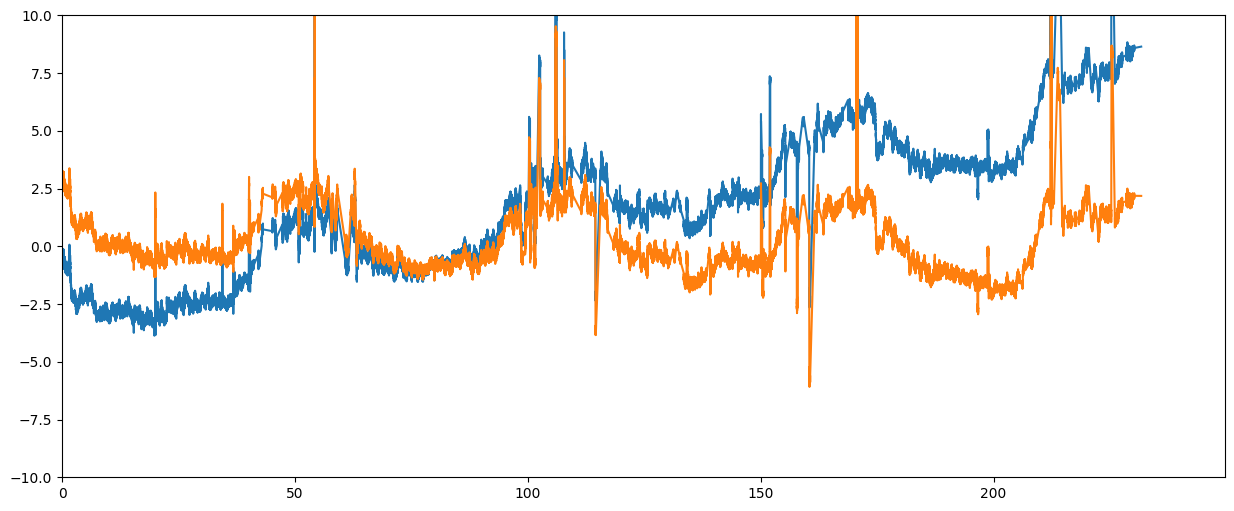

In [99]:

plt_3 = plt.figure(figsize=(15, 6))
time = (eye_data_runs_nan_blink_run_1[:,0] - eye_data_runs_nan_blink_run_1[0,0]) / 1000
x_eye = eye_data_x_run_01_nan_blink_interpol
x_eye_lin = 0.04 * time + 0.1 + x_eye
y_eye = eye_data_y_run_01_nan_blink_interpol

x_eye_detrend = detrending(x_eye_lin,'pRF')

plt.plot(time, x_eye_lin)
plt.plot(time, x_eye_detrend)
plt.ylim([-10,10])
plt.xlim([0,208*1.2])
plt.show()